# Comparing InfoGroup with County Business Patterns

This notebook logs a lot of preparations. Final figures are at the bottom.

Comparison by state, 2-digit NAICS industry and year. Years covered: 1998-2015.

## Download state level CBP data from Census

Raw text data files and documentation.

In [1]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

In [2]:
years = list(range(1986, 2016))
path_raw = 'raw/cbp{y}st.txt'
path_doc = 'raw/docs/{y}.txt'

In [4]:
def _make_dir(file_path):
    d = os.path.dirname(file_path)
    if not os.path.exists(d):
        os.makedirs(d)

_make_dir(path_raw)
_make_dir(path_doc)

In [5]:
def get_raw_data(y):
    y2 = str(y)[2:]
    dst = path_raw.format(y=y2)
    if os.path.exists(dst):
        print('get_raw_data: {} already exists'.format(dst))
        return
    
    print('get_raw_data: {y} started'.format(y=y))
    url = 'https://www2.census.gov/programs-surveys/cbp/datasets/{y4}/cbp{y2}st.zip'.format(y4=y, y2=y2)
    r = requests.get(url)
    if r.status_code != 200:
        print('get_raw_data: {y} failed: {e}'.format(y=y, e=r.reason))
        r.raise_for_status()
    
    zf = ZipFile(BytesIO(r.content))
    downloaded_name = zf.namelist()[0]
    zf.extractall()
    os.rename(downloaded_name, dst)
    print('get_raw_data: {y} finished'.format(y=y))

In [6]:
def get_raw_docs():
    print('get_raw_docs started')
    url_stub = 'https://www2.census.gov/programs-surveys/'
    urls = {
        '1986-1997': 'cbp/technical-documentation/records-layouts/full-layout/state_layout_sic.txt',
        '1998-2006': 'cbp/technical-documentation/records-layouts/full-layout/state_layout.txt',
        '2007-2009': 'cbp/technical-documentation/records-layouts/noise-layout/state_layout.txt',
        '2010-2013': 'cbp/technical-documentation/records-layouts/noise-layout/state_x_lfo_layout.txt',
        '2014': 'rhfs/cbp/technical%20documentation/2014_record_layouts/state_layout_2014.txt',
        '2015': 'rhfs/cbp/technical%20documentation/2015_record_layouts/state_layout_2015.txt'
    }
    for y, u in urls.items():
        url = url_stub + u
        r = requests.get(url)
        if r.status_code != 200:
            print('get_raw_docs: {y} failed: {e}'.format(y=y, e=r.reason))
            r.raise_for_status()
        
        with open(path_doc.format(y=y), 'w') as f:
            f.write(r.text)
    
    print('get_raw_docs finished')

In [7]:
for y in years:
    get_raw_data(y)
get_raw_docs()

get_raw_data: 1986 started
get_raw_data: 1986 finished
get_raw_data: 1987 started
get_raw_data: 1987 finished
get_raw_data: 1988 started
get_raw_data: 1988 finished
get_raw_data: 1989 started
get_raw_data: 1989 finished
get_raw_data: 1990 started
get_raw_data: 1990 finished
get_raw_data: 1991 started
get_raw_data: 1991 finished
get_raw_data: 1992 started
get_raw_data: 1992 finished
get_raw_data: 1993 started
get_raw_data: 1993 finished
get_raw_data: 1994 started
get_raw_data: 1994 finished
get_raw_data: 1995 started
get_raw_data: 1995 finished
get_raw_data: 1996 started
get_raw_data: 1996 finished
get_raw_data: 1997 started
get_raw_data: 1997 finished
get_raw_data: 1998 started
get_raw_data: 1998 finished
get_raw_data: 1999 started
get_raw_data: 1999 finished
get_raw_data: 2000 started
get_raw_data: 2000 finished
get_raw_data: 2001 started
get_raw_data: 2001 finished
get_raw_data: 2002 started
get_raw_data: 2002 finished
get_raw_data: 2003 started
get_raw_data: 2003 finished
get_raw_da

### Upload to CS

In [8]:
!gsutil -m cp -r -n raw/* gs://ig-census-cbp/raw/state/

Skipping existing item: gs://ig-census-cbp/raw/state/cbp08st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp03st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp10st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp07st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp04st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp00st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp15st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp13st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp02st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp09st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp05st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp14st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp06st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp12st.txt
Skipping existing item: gs://ig-census-cbp/raw/state/cbp94st.txt
Skipping existing item: g

## Explore CBP data and convert to pandas DataFrame


### Columns changed over years

In [21]:
import pandas as pd
path_raw.format(y='z')

'raw/cbpzst.txt'

In [22]:
# Read column lists for all years
raw_cols = {}
cols = {}
all_cols = []
for y in years:
    y2 = str(y)[2:]
    df = pd.read_csv(path_raw.format(y=y2), nrows=1)
    raw_cols[y] = list(df.columns)
    cols[y] = list(df.columns.str.lower())
    for c in cols[y]:
        if c not in all_cols:
            all_cols.append(c)

In [ ]:
# Create table where columns that existed in year are marked with 1s, otherwise 0
col_by_year = pd.DataFrame(0, index=all_cols, columns=years)
for y in years:
    col_by_year.loc[cols[y], y] = 1

pd.options.display.max_columns = 40
pd.options.display.max_rows = 100
col_by_year.loc[:, 1997:]

InfoGroup data goes 1997-2015. CBP changes over this period:
- switched from SIC to NAICS in 1998 (IG has both NAICS and SIC in 1997)
- `nf` columns since 2007 - Noise Flag, don't even need at this point
- `lfo` column since 2010 - Legal Form of Organization, interesting but also not important now

### Read CBP data into pandas

In [ ]:
years = list(range(1998, 2016))
path_raw = 'raw/cbp{y2}st.txt'

In [ ]:
df_raw = {}
for y in years:
    y2 = str(y)[2:]
    cols = ['fipstate', 'naics', 'emp', 'est']
    if y >= 2010: cols.append('lfo')
    if y == 2015: cols = [x.upper() for x in cols]
    df = pd.read_csv(path_raw.format(y2=y2), dtype='object', usecols=cols)
    if y == 2015: df.columns = df.columns.str.lower()
    if y >= 2010:
        df = df[df.lfo == '-']
        df = df.drop('lfo', axis=1)
    df = df[df.naics.str[2:] == '----']
    df_raw[y] = df

In [ ]:
# Eyeball read errors
for y in years:
    print(y, len(df_raw[y]), len(df_raw[y].fipstate.unique()), len(df_raw[y].naics.str[:2].unique()))

In [ ]:
state_codes = pd.read_csv('https://www2.census.gov/geo/docs/reference/state.txt', delimiter='|', dtype='object')
state_codes

In [ ]:
state_nn_to_aa = dict(zip(state_codes.STATE, state_codes.STUSAB))
state_nn_to_aa

In [ ]:
dfs = {}
for y, df in df_raw.items():
    df = df.copy()
    df.columns = ['state', 'naics', 'emp', 'est']
    df.state = df.state.map(state_nn_to_aa)
    df.naics = df.naics.str[:2]
    df = df[df.naics != '--']
    df = df.set_index(['state', 'naics'])
    dfs[y] = df

In [ ]:
cbp = pd.concat(dfs, axis=1)
cbp = cbp.astype(pd.np.float64)
cbp = cbp.swaplevel(0, 1, axis=1).sort_index(axis=1)

cbp.to_pickle('cbp_st_n2_y.gz')

cbp

## Query InfoGroup data and save as DataFrame


In [ ]:
import uuid
from google.cloud import bigquery
import pandas as pd

In [ ]:
def wait_for_job(job):
    import time
    while True:
        job.reload()  # Refreshes the state via a GET request.
        if job.state == 'DONE':
            if job.error_result:
                raise RuntimeError(job.errors)
            print('Job finished successfully in {}.'.format(job.ended - job.created))
            return
        time.sleep(1)

In [ ]:
# Something's wrong with this one, need to test and debug, or use pd.read_gbq()
def async_query(query):
    client = bigquery.Client()
    query_job = client.run_async_query(str(uuid.uuid4()), query)
    query_job.use_legacy_sql = False
    query_job.begin()

    wait_for_job(query_job)
    
    # Return results rows
    query_results = query_job.results()
    query_results.fetch_data()
    field_names = tuple([x.name for x in query_results.schema])
    return [field_names] + query_results.rows

In [ ]:
query = '''
SELECT
  substr(naics, 1, 2) as naics2,
  year,
  state,
  COUNT(*) as est,
  SUM(employees) as emp
FROM
  `original.data`
GROUP BY
  year, state, naics2
ORDER BY
  year, state, naics2;
'''

ig_raw = async_query(query)

In [ ]:
ig = pd.DataFrame(ig_raw[1:], columns=ig_raw[0])
ig.columns = ['naics', 'year', 'state', 'est', 'emp']

# naics = '99' is 'unknown industry'
ig = ig.fillna({'naics': '99', 'emp': 0})
ig = ig.groupby(['year', 'state', 'naics']).sum()
ig = ig.unstack('year')

ig

In [ ]:
ig.to_pickle('ig_st_n2_y.gz')

## Align CBP and IG dataframes for comparison

### Get NAICS descriptions

In [ ]:
# NAICS descriptions
url = {
    1997: 'https://www.census.gov/eos/www/naics/reference_files_tools/1997/1997.html',
    2002: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2002',
    2007: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2007',
    2012: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2012',
    2017: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2017'
}

naics = {}
for y, u in url.items():
    naics[y] = pd.read_html(u)[0]

In [ ]:
# what changed over years?
naics_years = list(naics.keys())
for y0, y1 in zip(naics_years[:-1], naics_years[1:]):
    print(y0, y1)
    print((naics[y0] == naics[y1]).sum())

In [ ]:
# the only difference was "Mining" changed to "Mining, Quarrying, and Oil and Gas Extraction" between 2002 and 2007.
pd.concat([naics[2002], naics[2007]], axis=1)

In [ ]:
# map codes into descriptions, using 2012 table
y = 2012
codes = naics[y].iloc[1:, 0]
codes = codes.str[:2]
desc = naics[y].iloc[1:, 1]
naics = dict(zip(codes, desc))
naics['99'] = 'Unknown'

In [ ]:
cbp = pd.read_pickle('cbp_st_n2_y.gz')
cbp.index.get_level_values('naics').unique()
# for ranges in description table, only first number appears in cbp tables: "48-49" - only "48", etc.

ig = pd.read_pickle('ig_st_n2_y.gz')

In [ ]:
cbp_rows = pd.Series(index=cbp.index)
cbp_rows = cbp_rows.fillna(True).astype(bool)
ig_rows = pd.Series(index=ig.index)
ig_rows = ig_rows.fillna(True).astype(bool)
common_rows = pd.concat([cbp_rows, ig_rows], axis=1).fillna(False)
common_rows.columns = ['cbp', 'ig']
common_rows[~common_rows.all(1)]

In [ ]:
# Range codes should be combined in IG: "31-33", "44-45", "48-49".
ig = ig.reset_index()
ig.naics = ig.naics.replace({'32': '31', '33': '31', '45': '44', '49': '48'})
ig = ig.groupby(['state', 'naics']).sum()

In [ ]:
# Why is 95 in CBP? Is it '92': 'Public Administration'? For now, let's assume it is.
cbp.index = cbp.index.set_levels(pd.Series(cbp.index.levels[1]).replace({'95': '92'}), level=1)

In [ ]:
# Repeat same check: PR and VI states missing in CBP
cbp_rows = pd.Series(index=cbp.index)
cbp_rows = cbp_rows.fillna(True).astype(bool)
ig_rows = pd.Series(index=ig.index)
ig_rows = ig_rows.fillna(True).astype(bool)
common_rows = pd.concat([cbp_rows, ig_rows], axis=1).fillna(False)
common_rows.columns = ['cbp', 'ig']
common_rows['both'] = common_rows.cbp & common_rows.ig
common_rows[~common_rows.both]

### Save comparison ready tables

In [ ]:
idx = pd.IndexSlice
ig.loc[common_rows.both, idx[:, 1998:]].to_pickle('ig_cmp.gz')
cbp.loc[common_rows.both, :].to_pickle('cbp_cmp.gz')

In [ ]:
!gsutil cp *cmp.gz gs://ig-anton/

# Visually compare IG vs CBP

Every chart shows IG-to-CBP ratios of total number of establishments or employment in a given cell. Values greater or less than 1 imply that IG overstates or understates CBP numbers, respectively. 

In [1]:
%%bash
# download comparison-ready tables to local disk
gsutil cp gs://ig-anton/ig_cmp.gz .
gsutil cp gs://ig-anton/cbp_cmp.gz .

Copying gs://ig-anton/ig_cmp.gz...
/ [1 files][120.1 KiB/120.1 KiB]                                                
Operation completed over 1 objects/120.1 KiB.                                    
Copying gs://ig-anton/cbp_cmp.gz...
/ [1 files][112.9 KiB/112.9 KiB]                                                
Operation completed over 1 objects/112.9 KiB.                                    


In [2]:
# Load data
import pandas as pd
ig = pd.read_pickle('ig_cmp.gz')
cbp = pd.read_pickle('cbp_cmp.gz')
naics = {
    '11': 'Agriculture, Forestry, Fishing and Hunting',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade',
    '48': 'Transportation and Warehousing',
    '51': 'Information',
    '52': 'Finance and Insurance',
    '53': 'Real Estate and Rental and Leasing',
    '54': 'Professional, Scientific, and Technical Services',
    '55': 'Management of Companies and Enterprises',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '71': 'Arts, Entertainment, and Recreation',
    '72': 'Accommodation and Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration',
    '99': 'Unknown'}
naics = {k: k + ' - ' + v for k, v in naics.items()}

In [3]:
# Compute IG / CBP ratios
dif = {}
idx = pd.IndexSlice
for var in ['emp', 'est']:
    dif[var] = {}
    ig_cmp = ig.loc[:, idx[var, :]]
    cbp_cmp = cbp.loc[:, idx[var, :]]        
    
    for agg in ['state', 'naics']:
        dif[var][agg] = d = ig_cmp.sum(level=agg) / cbp_cmp.sum(level=agg)
        d.loc['total', :] = ig_cmp.sum() / cbp_cmp.sum()

In [10]:
# Prepare plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, SelectMultiple, Layout, fixed

def show_by_naics(codes, var):
    rows = list(codes) + ['total']
    row_names = [naics[x] for x in codes] + ['total']
    d = dif[var]['naics']
    d = d.loc[rows, :]
    d.index = row_names
    sns.heatmap(d)
    plt.show()

## Establishments by state and year

/home/anton/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


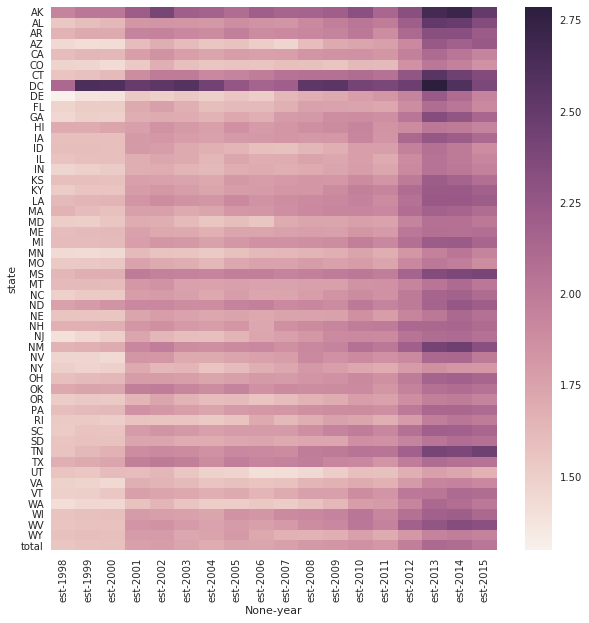

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(dif['est']['state'])
plt.show()

## Employment by state and year

/home/anton/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


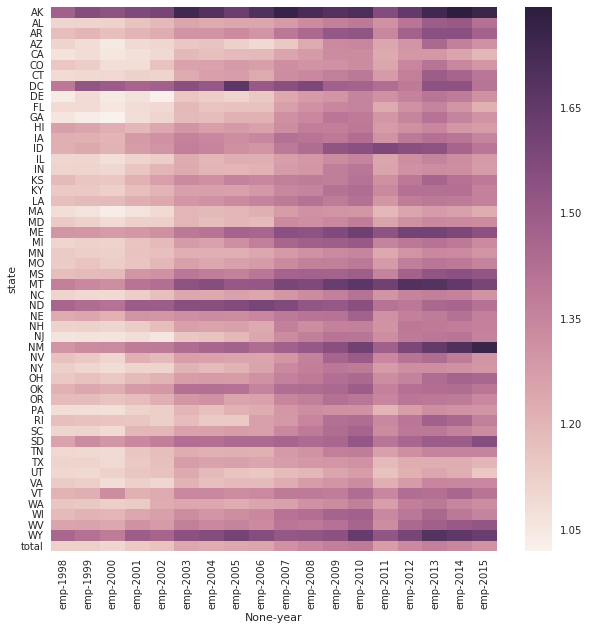

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(dif['emp']['state'])
plt.show()

## Establishments by industry and year

Interactive: Select industry codes to display with ctrl+click and shift+click.

In [11]:
naics_selector = SelectMultiple(
    options=tuple(naics.keys()),
    value=tuple(naics.keys()),
    description='NAICS codes'
)

void = interact(show_by_naics, codes=naics_selector, var=fixed('est'))

### Exclude some outliers

In [12]:
outliers = ['11', '61', '92', '99']
print('Excluded codes:')
for x in outliers: print(naics[x])
keep = [x for x in naics.keys() if x not in outliers]

naics_selector = SelectMultiple(
    options=tuple(naics.keys()),
    value=tuple(keep),
    description='NAICS codes'
)

void = interact(show_by_naics, codes=naics_selector, var=fixed('est'))

Excluded codes:
11 - Agriculture, Forestry, Fishing and Hunting
61 - Educational Services
92 - Public Administration
99 - Unknown


## Employment by industry and year

In [13]:
naics_selector = SelectMultiple(
    options=tuple(naics.keys()),
    value=tuple(naics.keys()),
    description='NAICS codes'
)

void = interact(show_by_naics, codes=naics_selector, var=fixed('emp'))

### Exclude some outliers

In [14]:
outliers = ['11', '61', '92', '99']
print('Excluded codes:')
for x in outliers: print(naics[x])
keep = [x for x in naics.keys() if x not in outliers]

naics_selector = SelectMultiple(
    options=tuple(naics.keys()),
    value=tuple(keep),
    description='NAICS codes'
)

void = interact(show_by_naics, codes=naics_selector, var=fixed('emp'))

Excluded codes:
11 - Agriculture, Forestry, Fishing and Hunting
61 - Educational Services
92 - Public Administration
99 - Unknown


# Conclusions
- In aggregate, IG shows 50-100% more establishments and 10-30% more employees than CBP
- Difference grows over time
- There are not many outliers across states
- Very strong outliers in industries: too much 99, 92, 11, 61, too little 55
- Patterns are similar between establishments and employment